In [1]:
import platform 
import os, time
# dictionary 
info = {} 
  
platform_details = platform.platform() 
info["platform details"] = platform_details 
system_name = platform.system() 
info["system name"] = system_name 
processor_name = platform.processor() 
info["processor name"] = processor_name 
architecture_details = platform.architecture() 
info["architectural detail"] = architecture_details 
for i, j in info.items(): 
    print(i, " - ", j) 
print(time.strftime('%X'))
print(os.getcwd())

platform details  -  Windows-10-10.0.19041-SP0
system name  -  Windows
processor name  -  Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
architectural detail  -  ('64bit', 'WindowsPE')
14:26:15
C:\Users\sd\notebooks\MAIN_PRJWindows\AddConstToObj


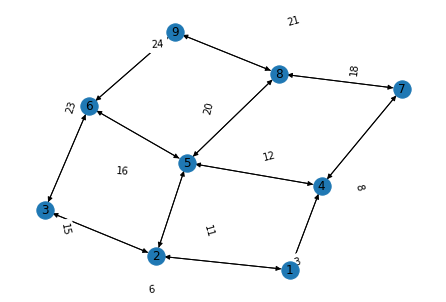

In [2]:
import networkx as nx
import sqlite3 
import os
import sys
import numpy as np
from sklearn.linear_model import LinearRegression

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sdNetworkUtility  import *
from sdTapPyomo  import *
from sdLIPSolverAddConstToObj  import *
#----------------------------------
#در ساختار شبکه در جدول نودها فرض شده که نودهایی که می توانند مبدا یا مقصد یک زوج مبدا مقصد باشند(زون هستند)در همان ابندای جدول و از اندیس
#1 - n
#آمده اند و فیلد 
#is_OD 
#آنها 1 است
np. set_printoptions(threshold=np. inf)

# Create a SQL connection to our SQLite database               # 9Nodes  SiouxFalls Anaheim
con = sqlite3.connect("C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/1_project/9Nodes/project_database.sqlite")
cur = con.cursor()
G = nx.DiGraph()
#مشخص کردن تعداد ODها
cur.execute('SELECT count(is_OD) FROM nodes where is_OD = 1 ')
Data= cur.fetchall()
NodeODCount =Data[0][0] #تعداد نودهایی که مبدا یا مقصد هستند(زون هستند) 
ODCount = NodeODCount**2
#-------------
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
#----------رسم گراف شبکه----

sdDrawGraph(nx,G)

ODNumber_Matrix = sdGet_ODNumber_Matrix(NodeODCount)
n,m = np.shape(ODNumber_Matrix)

# تقاضا بین زوجها
ODDeman_Matrix = pd.read_excel(r'C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/0_tntp_data/9Nodes/xod.xlsx',sheet_name='Sheet1')
ODDeman_Vector = np.zeros(ODCount) 
for i in range(n):
     for j in range(m):
        ODDeman_Vector[ODNumber_Matrix[i,j] - 1] = ODDeman_Matrix.iloc[i,j]

#--تعریف ساختمان داده های لازم
#لیست تمام یالهای گراف را میدهد اما نامرتب
edgs = list(G.edges(data=True))

#مرتب کردن یالها بر اساس شماره لینک
LinksList =  list(np.zeros(len(edgs)))
for row in edgs:
    LinksList[row[2]['link_id'] -1] = row
 
 
#فقط برای نودهای مبدا-مقصد که در اول لیست نودها هم هستند 3 کوتاهترین مسیرها محاسبه می شود
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)

        #ماتریس تعیین عضویت هر زوج در هر مسیر
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

#P_i: set of paths between origin-destination in I
LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        



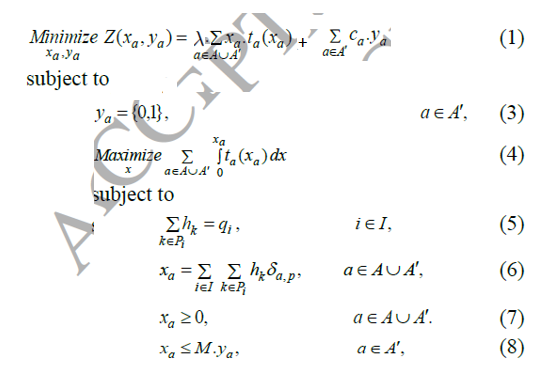

In [3]:
#--Calculate High Level Objective Function
# free Flow Time به دقیقه
#زمان سفر کل بر حسب دقیقه در روز
#ظرفیت  بر حسب تعداد خودرو در روز
#جریان  بر حسب تعداد خودرو در روز
# تعداد خودرو در روز تقاضای سفر بر حسب

def CalcZ(intObjectiveFunc,X,Capacity,Tzero,Cost,linksY, Min1=0,Max1=0,Min2 = 0,Max2=0, Landa= 1):
    #ایران
    #GDP = 2282 * 280000  #ریال
    #TW = 365 * 8
    #VOT = GDP / TW  ارزش یک ساعت کار
   #------------------
    #آمریکا
    GDP = 63543  #دلار
    TW = 365 * 5 # 
    VOT = GDP / TW  #  ارزش یک ساعت کار
    VOT = VOT / 60 #ارزش یک دقیقه کار
    if intObjectiveFunc == 1: #فقط زمان سفر کل
        return sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) )
    elif intObjectiveFunc == 2: #فقط هزینه ساخت
        return sum(Cost[z] * linksY[z] for z in range(len(Cost)))
    elif intObjectiveFunc == 3: #  در رنج 1 هر دو
        C1 = Max1 - Min1
        C2 = Max2 - Min2
        return ( Landa * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) - Min1) /C1)  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) - Min2) / C2) )  
    elif intObjectiveFunc == 4: # هر دو
        return ( Landa * VOT * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) ))  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) ) ) )  
    

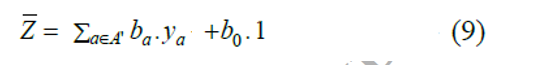

Satrt Time: 15:45:17


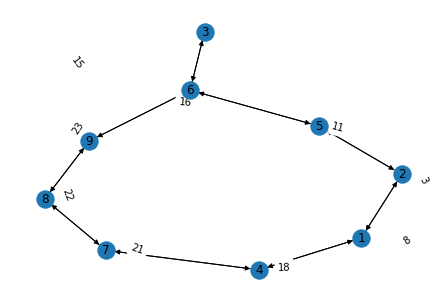

In [22]:
print('Satrt Time: '+time.strftime('%X'))

Landa =9

#Anaheim
#NewLinkIds = np.array([636,719, 771,718 ,665,699, 414,451, 428,483])
#NewLinkCost = np.array([44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9,44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9])

#SiouxFalls
#NewLinkIds = np.array([1,3, 12,15 ,33,36, 47,46, 50,55])
#NewLinkCost = np.array([2.4 * 10**6, 2.4 * 10**6, 2.1 * 10**6, 2.1 * 10**6, 2.2 * 10**6,2.2 * 10**6, 1.9 * 10**6, 1.9 * 10**6, 1.8 * 10**6, 1.8 * 10**6])


#9Nodes
NewLinkIds = np.array([4,6,9,12,14,20]) 
NewLinkCost = np.array([8 * 10**3, 1.8 * 10**3,9 * 10**3,7 * 10**3,6 * 10**3,10 * 10**3])


#حذف لینکهای جدید از شبکه برای آماده کردن شبکه
strLinksForRemove = '-1'
for lkid in NewLinkIds:
    strLinksForRemove = strLinksForRemove + ',' + str(lkid)
#---دور اول ---
y =  np.array([[0] * len(NewLinkIds)])#انداره y  لینکهای جدید به تعداد

    
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data:
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
LinksList = list(G.edges(data=True))
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)


LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )
#total flow on the path k in P_ij = _fijk         جریان در کاامین مسیر از زوج آی و جی

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
#-------------------------------
sdDrawGraph(nx,G)

flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
#print('flows',flows)

#Maximum of TotalTravelTime Occured when all y are 0
#MaxTotalTravelTime = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 
#MinCostForNewLinks = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 

#print('y = ', y[0][:len(y[0])])
#print('MaxTotalTravelTime = ', MaxTotalTravelTime)

#---Calculate z base on flows---
z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],
          0,0,0,0, Landa)

#print('z',z)
# ---Adding Curent z To Z vector---
Z = np.array( [z])
#print('Z',Z)

Y= np.array(y)


In [23]:


#---حلقه اصلی برنامه----
print('Satrt Time: '+time.strftime('%X'))
TedadTekrar = pow(2,len(NewLinkIds))
for Idx in range(TedadTekrar):#Main Loop
        print("شماره تکرار:  ",Idx)
        StrBinIdx =  str(bin(Idx))[::-1]
        y =  [int(d) for d in StrBinIdx[:len(StrBinIdx)-2]]
        y = y[:len(NewLinkIds)] + [0]*(len(NewLinkIds) - len(y)) 
        y = [y]
        print("y:  ",y)
    #---Create Network Base  On current y---
        strLinksForRemove = '-1'
        for i in range(len(y[0])):
            if y[0][i] == 0:
                strLinksForRemove = strLinksForRemove + ',' + str(NewLinkIds[i])
                
        #DrawNetwork(prj)
       #---ساخت مجدد شبکه با اعمال تغییرات لینکها 
        cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
        Data= cur.fetchall()
        G.clear()
        for row in Data:
            G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
        LinksList = list(G.edges(data=True))
        All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
        DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
                #ماتریس تعیین عضویت هر لینک در هر مسیر
        DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

        #P_i: set of paths between origin-destination in I
        LinkCount = len(LinksList) 
        PathCount = len(All_KshortestPathList )
       

        LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

        LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        #-------------------------------
        
        #---Solve TAP and calculate flows---
        flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
        #print('flows',flows)
        #---Calculate z base on flows---
        #z1 = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #z2 = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #print("z1 = ",z1)
        #print("z2 = ",z2)

       
        z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],
          0,0,0,0, Landa)
        print("z = ",z)

        # ---Adding Curent z To Z vector---
        Z = np.append(Z,[z], axis = 0) 

        #========REGRESSION===========
        Y= np.append(Y, y, axis = 0)
    
print('********************************************')
print('********************************************')
#print('MinTotalTravelTime = ', MinTotalTravelTime)
#print('MaxTotalTravelTime = ', MaxTotalTravelTime)
#print('MinCostForNewLinks = ', MinCostForNewLinks)
#print('MaxCostForNewLinks = ', MaxCostForNewLinks)



print('Min Of Z = ',np.amin(Z), '  Where is in  ',np.where(Z == np.amin(Z)))
 
print('Max Of Z = ',np.amax(Z), '  Where is in  ',np.where(Z == np.amax(Z)))

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)

print('Finish Time: '+time.strftime('%X'))


Satrt Time: 15:45:20
شماره تکرار:   0
y:   [[0, 0, 0, 0, 0, 0]]
z =  325851.9868374104
شماره تکرار:   1
y:   [[1, 0, 0, 0, 0, 0]]
z =  317313.0122586281
شماره تکرار:   2
y:   [[0, 1, 0, 0, 0, 0]]
z =  312687.7498656807
شماره تکرار:   3
y:   [[1, 1, 0, 0, 0, 0]]
z =  300977.9089461212
شماره تکرار:   4
y:   [[0, 0, 1, 0, 0, 0]]
z =  320680.49144289107
شماره تکرار:   5
y:   [[1, 0, 1, 0, 0, 0]]
z =  313798.78935739934
شماره تکرار:   6
y:   [[0, 1, 1, 0, 0, 0]]
z =  306898.31486007845
شماره تکرار:   7
y:   [[1, 1, 1, 0, 0, 0]]
z =  297451.7646823531
شماره تکرار:   8
y:   [[0, 0, 0, 1, 0, 0]]
z =  300643.56997003366
شماره تکرار:   9
y:   [[1, 0, 0, 1, 0, 0]]
z =  291731.8371492639
شماره تکرار:   10
y:   [[0, 1, 0, 1, 0, 0]]
z =  291593.9243728627
شماره تکرار:   11
y:   [[1, 1, 0, 1, 0, 0]]
z =  281246.5027982071
شماره تکرار:   12
y:   [[0, 0, 1, 1, 0, 0]]
z =  292106.84988992807
شماره تکرار:   13
y:   [[1, 0, 1, 1, 0, 0]]
z =  285748.76782187127
شماره تکرار:   14
y:   [[0, 1, 1, 1, 0, 0]]
z

In [ ]:
import matplotlib.pyplot as plt 
print('Z = ',Z)
print('====================================')
print('Y = ',Y)
print('====================================')

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)
plt.plot(Z)
plt.xlabel('Iterations') 
plt.ylabel('Objective Value') 
plt.show()
#plt.title('$𝑝_1$ = 2,  $𝑝_2$ <=6 and Budget=350') 
#plt.savefig("E:/paper/paper/new version/Bi-level deep learning/ver2/fig 4 node/fig4.png",dpi=200,facecolor ="w",edgecolor ='w',orientation ='landscape')